In [1]:
#Various imports we use
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import SGD
import os
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks
import utils

In [12]:
#This is a very basic example of loading some data, training the model, and 
#performing predictions on a test dataset

### These first few lines are specifically for the utils.import_data method, and aren't strictly necessary
### if you have your own pipeline.
########################
#Selected Auriga halo
HALO = 14
#Total number of training particles
N_TRAINING = 80000
#maximum alpha/Fe allowed, due to low Fe this is required
alphaMax = 1e10
#noise to add to chemical data
NOISE = 0
#columns of data to drop/ignore before feeding into the model
DROP_COL = ['X','Y','Z','M','R', 'epsJ', 'Ne', 'Mg', 'C','N','He', 'Si', 'O', 'z', 'Vr', 'BE', 'Lz', 'pkmassid'] #


#Import the disc's data, and make a full copy with all the information for later
training_data = utils.import_data(to_drop = [], dat=False,alpha_max=alphaMax,chem_noise = NOISE)

#Remove the to-drop data from the set we'll continue with
data = training_data.drop(DROP_COL, axis=1)

#If you're loading from multiple sources, you can construct multiple datasets with a loop
#combine them into a list data_app = [tdata1, tdata2,...]
#and the concatenate them into a combined training set!
#We then use .sample(frac=1) to shuffle everything
data_app = [data]
data_t = pd.concat(data_app,ignore_index=True).sample(frac=1)

#Important for GANN is that this training data is uniformly considered to be accreted
#EVEN IF IT's NOT TRUE!
#This is mimicking observational constraints
#Not to mention, this training set should be halo and satellite stars,
#Sats are obviously really "accreted", but the halo should be >99%
#So we set the acc_label column to a ones vector of the same size
data_t['acc_label'] = np.ones(data_t.index.values.shape[0])

#Now, we want the length of the training data, so that we can sample an equal number
#of particles from the test data set (the disc!)
#You can, alternatively, generate your own in-situ training data,
#using clever slices of stars to minimize the chance of contamination
#but for the paper I didn't, because examining worst-cases is more interesting
N = data_t.index.shape[0]
N = int(min(N,N_TRAINING/2)) #If N > the number we want, we'll subsample
acc_dat = data_t.sample(n=N) #this will just shuffle if N <= N_TRAINING
#We've now generated the accreted half of our training set!
#Now on to the in-situ, which we'll sample from the "evaluation" disc data
#under the assumption that f_acc in the disc is low.
#Not technically safe, but we're pretending to be more constrained than we are!
#there *will* be contamination, because f_acc *should* be > 0 (otherwise it's a boring search haha)

#Make a full copy - for use in visualization of correlations, etc.
#This is *very* useful, as you can train the model on the restricted set,
#create filters based on the labels, and apply those filters to the 
#full testing set! That way you can examine values that you don't
#use in the network itself
test_dat_full = utils.import_data(to_drop = [], dat=True, alpha_max=alphaMax,chem_noise = NOISE)
#Grab a chunk of data to use in the training set
#the number should match the size of the accreted contribution
print("Using %d"%(N))
ins_dat = test_dat_full.sample(n=N)
#remove unncessary columns from in-situ training data
ins_dat = ins_dat.drop(DROP_COL, axis=1)
#for the training data, we set its label to 0
ins_dat['acc_label'] = np.zeros(ins_dat.index.values.shape[0])

#build the full training set by concatenating the acc and ins data
train_dat = pd.concat([acc_dat, ins_dat],ignore_index=True).sample(frac=1)
#we pop off the labels for comparison/validation
train_lab = train_dat.pop('acc_label')

#We take the rest and create the validation set, with labels
test_dat = test_dat_full.copy()
#Once again, remove the unneeded columns from the data
test_dat = test_dat.drop(DROP_COL, axis=1)
#and pop off the labels for later!
test_lab = test_dat.pop('acc_label')

Using 40000


In [20]:
Nmul = 1
N_NEURON_BASE = 32
#Here we define the model's layers
#I've set it up to use the length of the training data's keys as the input vector size,
#which means the network will adjust as you add/remove data columns
model = tf.keras.Sequential([
    #the batchnorm layer will help with performance a ton, and prevent 
    #larger input values from initially dominating while the network
    #"learns" to adjust those weights
    tf.keras.layers.BatchNormalization(input_shape=[len(train_dat.keys())]),  
    #Next are all dense (interconnected) layers, where the deep-learning happens
    tf.keras.layers.Dense(Nmul * 2 * N_NEURON_BASE,activation=tf.nn.selu,kernel_initializer=tf.keras.initializers.lecun_normal(seed=None)),
    tf.keras.layers.Dense(Nmul * 8 * N_NEURON_BASE,activation=tf.nn.selu,kernel_initializer=tf.keras.initializers.lecun_normal(seed=None)),
    tf.keras.layers.Dense(Nmul * 2 * N_NEURON_BASE,activation=tf.nn.selu,kernel_initializer=tf.keras.initializers.lecun_normal(seed=None)), ##New
    tf.keras.layers.Dense(Nmul * N_NEURON_BASE,activation=tf.nn.selu,kernel_initializer=tf.keras.initializers.lecun_normal(seed=None)),
    #finally, our output uses a single sigmoid neuron to output a probability-like value
    #(can't say probability, because a statistician might get mad)
    tf.keras.layers.Dense(1,activation='sigmoid')
])
#the compilation info
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              #We use BCE, because it's perfect for this use-case
              loss=tf.keras.losses.BinaryCrossentropy(), 
              #We sorta care about accuracy, but definitely about false positives
              metrics=['accuracy',tf.keras.metrics.FalsePositives(thresholds=0.5)])
tf.get_logger().setLevel('ERROR')
#Set up early stopping and plateau learning-rate reduction
#optional, and can sometimes make the model give up on improving
#earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='auto',restore_best_weights=True)
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=0, verbose=1, epsilon=1e-4, mode='min')
#and here we execute the fitting procedure, and save the model
model.fit(train_dat, train_lab, epochs=30)#, callbacks=[earlyStopping,reduce_lr_loss])
model.save("models/auriga_test.h5")

Epoch 1/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2700 - accuracy: 0.8936 - false_positives_6: 2979.2363
Epoch 2/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2316 - accuracy: 0.9118 - false_positives_6: 2824.6605
Epoch 3/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2332 - accuracy: 0.9091 - false_positives_6: 2877.5722
Epoch 4/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2255 - accuracy: 0.9142 - false_positives_6: 2810.3259
Epoch 5/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2249 - accuracy: 0.9137 - false_positives_6: 2842.5910
Epoch 6/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2238 - accuracy: 0.9144 - false_positives_6: 2814.6781
Epoch 7/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2227 - accuracy: 0.9140 - false_positives_6: 2819.9816
Epoch 8/30
2500/2500 [==============================] - 3s 1ms/step -

Correct:  0.6814622746114873
Incorrect:  0.10726104979444226


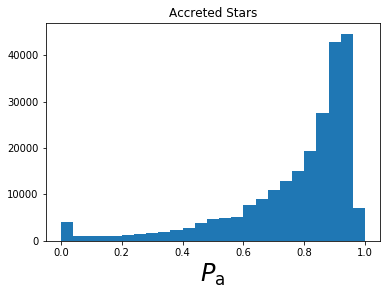

Correct:  0.9572374767241588
Incorrect:  0.04276252327584122


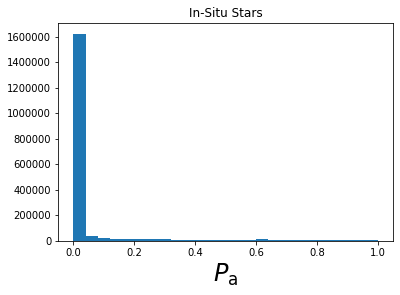

In [21]:
#how's it doing for accreted stars
#the model save/load between cells isn't strictly necessary,
#but ipython notebooks allow us to not have to re-run the entire program to use 
#the generated model!
#Here we load the saved model:
model = keras.models.load_model("models/auriga_test.h5")
#And we'll compare its performance with the accreted evaluation stars:
pred_acc = model.predict(test_dat.loc[test_lab == 1])
THRESHOLD = 0.75
#We can then split this pop into correct (P_a > THRESHOLD)
guess_acc_fi = (pred_acc >= THRESHOLD)
#And those below 0.5
#We leave the between-ers in a sort of "limbo"
#since the model considers them likely-accreted (>0.5),
#but it's not confident enough for us to care
wrong_guess_acc_fi = (pred_acc < 0.5)
#output the performance fractions
print("Correct: ",1.0*len(pred_acc[guess_acc_fi])/ len(pred_acc))
print("Incorrect: ",1.0*len(pred_acc[wrong_guess_acc_fi])/ len(pred_acc))
#And create a quick histogram of the P_a distribution of accreted stars
plt.hist(pred_acc, bins=25)
plt.title("Accreted Stars")
plt.xlabel(r"$P_{\rm a}$",fontsize=24)
plt.show()
plt.close()

#Now we select the in-situ stars
pred_ins = model.predict(test_dat[test_lab == 0])
#and do the same. 
#For in-situ, incorrect is P_a > 0.5
guess_acc_fi = (pred_ins < 0.5)
wrong_guess_acc_fi = (pred_ins >= 0.5)
print("Correct: ",1.0*len(pred_ins[guess_acc_fi])/ len(pred_ins))
print("Incorrect: ",1.0*len(pred_ins[wrong_guess_acc_fi])/ len(pred_ins))
#And make a pretty little histogram
plt.hist(pred_ins, bins=25)
plt.title("In-Situ Stars")
plt.xlabel(r"$P_{\rm a}$",fontsize=24)
plt.show()
plt.close()